In [1]:
import numpy as np 
import pandas as pd 
import h5py 
%matplotlib inline 

In [97]:
figname='lb'
h5file=h5py.File("/Users/pablo/Development/PostNewton3BP/exe/Fig3_"+figname+"/output.h5")

In [98]:
def get_waves(h5file):
    l_modes=[2,3] 
    columns=["t"]
    name=["Q","O","CQ"]
    for l in l_modes:
        for p in ['R','I']:
            for m in np.arange(start=-l,stop=l+1):
                columns.append(p+'['+name[l-2]+'m='+str(m)+"]")
    l=3
    for p in ['R','I']:
        for m in np.arange(start=-l,stop=l+1):
            columns.append(p+'['+name[l-1]+'m='+str(m)+"]")
    return pd.DataFrame(h5file['0']['waves'][:],columns=columns)       
    
df_waves=get_waves(h5file).set_index('t')

In [99]:
def get_dynamic_variable(h5file, dataset):
    Np=h5file['0'][dataset].attrs['np'][0]
    Dim=h5file['0'][dataset].attrs['dim'][0]
    coord=['x','y','z']    
    cols=['t']
    for p in np.arange(Np):
        for i in np.arange(Dim):
            cols.append(coord[i]+str(p+1))
    return pd.DataFrame(h5file['0'][dataset][:],columns=cols)


df_x=get_dynamic_variable(h5file, "position").set_index('t')
df_p=get_dynamic_variable(h5file, "momentum").set_index('t')

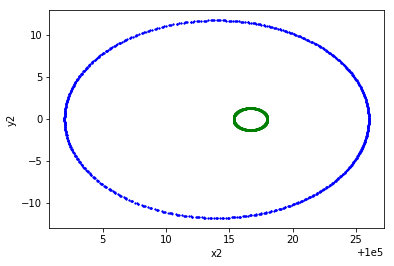

In [100]:
ax=df_x.plot.scatter(x='x1',y='y1',s=1,c='g')
ax=df_x.plot.scatter(x='x2',y='y2',s=1,c='b',ax=ax)


In [101]:
df_x[df_x['x1']>1.999804] #.plot()

,x1,y1,x2,y2
t,,,,
0.000000,100018.000000,0.000000,100002.000000,0.000000
1.079152,100017.999773,-0.024129,100002.002047,0.217165
2.138543,100017.999107,-0.047810,100002.008039,0.430293
3.344024,100017.997816,-0.074741,100002.019655,0.672665
4.641585,100017.995793,-0.103698,100002.037864,0.933282
6.009759,100017.992948,-0.134185,100002.063469,1.207663
7.437627,100017.989201,-0.165936,100002.097195,1.493422
8.918242,100017.984476,-0.198772,100002.139717,1.788949
10.446583,100017.978704,-0.232554,100002.191661,2.092989


In [102]:
df_waves.to_csv('fig3_'+figname+'_wave.gp',sep='\t')

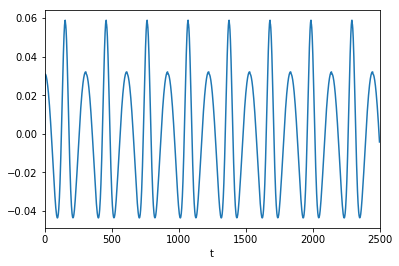

In [103]:
df_waves['R[Qm=2]'].plot()

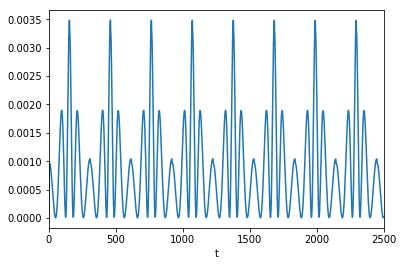

In [107]:
(df_waves['R[Qm=2]']**2+df_waves['R[Qm=0]']**2).plot()

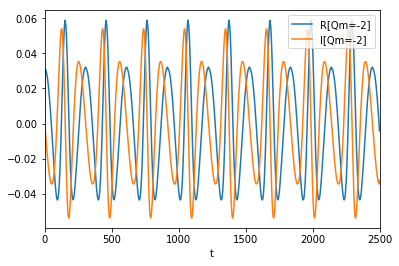

In [116]:
df_waves.iloc[:,(0,5)].plot()

In [114]:
df_waves

,R[Qm=-2],R[Qm=-1],R[Qm=0],R[Qm=1],R[Qm=2],I[Qm=-2],I[Qm=-1],I[Qm=0],I[Qm=1],I[Qm=2],...,R[CQm=1],R[CQm=2],R[CQm=3],I[CQm=-3],I[CQm=-2],I[CQm=-1],I[CQm=0],I[CQm=1],I[CQm=2],I[CQm=3]
t,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1.079152,0.027204,-0.0,0.001078,0.0,0.027204,-0.000859,-0.0,0.0,-0.0,0.000859,...,0.0,-0.0,15.010367,0.0,-15.010367,-0.0,0.0,-0.0,15.010367,0.0
2.138543,0.029884,-0.0,-0.001144,0.0,0.029884,-0.001886,-0.0,0.0,-0.0,0.001886,...,0.0,-0.0,25.121428,0.0,-25.121428,-0.0,0.0,-0.0,25.121428,0.0
3.344024,0.030691,-0.0,-0.001872,0.0,0.030691,-0.003072,-0.0,0.0,-0.0,0.003072,...,0.0,-0.0,28.377250,0.0,-28.377250,-0.0,0.0,-0.0,28.377250,0.0
4.641585,0.030895,-0.0,-0.002148,0.0,0.030895,-0.004344,-0.0,0.0,-0.0,0.004344,...,0.0,-0.0,29.537556,0.0,-29.537556,-0.0,0.0,-0.0,29.537556,0.0
6.009759,0.030869,-0.0,-0.002284,0.0,0.030869,-0.005680,-0.0,0.0,-0.0,0.005680,...,0.0,-0.0,30.014156,0.0,-30.014156,-0.0,0.0,-0.0,30.014156,0.0
7.437627,0.030713,-0.0,-0.002366,0.0,0.030713,-0.007067,-0.0,0.0,-0.0,0.007067,...,0.0,-0.0,30.196167,0.0,-30.196167,-0.0,0.0,-0.0,30.196167,0.0
8.918242,0.030455,-0.0,-0.002419,0.0,0.030455,-0.008496,-0.0,0.0,-0.0,0.008496,...,0.0,-0.0,30.201387,0.0,-30.201387,-0.0,0.0,-0.0,30.201387,0.0
10.446583,0.030102,-0.0,-0.002455,0.0,0.030102,-0.009959,-0.0,0.0,-0.0,0.009959,...,0.0,-0.0,30.072888,0.0,-30.072888,-0.0,0.0,-0.0,30.072888,0.0
